<a href="https://colab.research.google.com/github/Rontu22/FaceAndEyeDetectionUsingOpenCV/blob/master/PintoDetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
pip install ndlib

     |████████████████████████████████| 102kB 3.5MB/s 
     |████████████████████████████████| 3.2MB 7.2MB/s 


In [14]:
import networkx as nx
import numpy
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

In [15]:

## This function is going to give us a 2D delay matrix by taking 
## a graph "graph" and a list of reporting time of observers "ObserversList"
def observed_delay(graph,ObserversList):
    ##delay_matrix : is the required column matrix where the observers will be reporting the 
    ##               infected time 
    ## graph : is the given graph network consisting of both infected and noninfected nodes 
    ## here we are taking the Observers List as :
    ## [22, 65, 26, 115, 7, 14, 49, 2, 111, 69, 92]
    delay_matrix = numpy.zeros(shape=(len(ObserversList)-1,1))

    for observer in range(len(ObserversList)-1):
        delay_matrix[observer][0] = graph.nodes[ObserversList[observer+1]]['time'] - graph.nodes[ObserversList[observer]]['time']
    return delay_matrix



In [16]:
# This function is going to calculate how delay is scattered in the network
# Tree : tree formed by the list of Observers , this is mainly a bfs traversal tree of the graph
# ObserversList : List of observers in the network , here we are taking the following
#                 list of nodes as observers :-
#                 [22, 65, 26, 115, 7, 14, 49, 2, 111, 69, 92]
# sigmaSquared : variance of observed dalay
                

def delay_covariance(Tree,ObserversList,sigmaSquared):
    number_of_observers = len(ObserversList)
    # The following difference matrix is a square matrix which will be storing
    # the sortest paths between the infected observers
    difference_matrix = numpy.zeros(shape=(number_of_observers-1,number_of_observers-1))
    # Now convert the tree(another form of graph) to undirected
    # means if the graph had edges like [(1,2),(2,1)] instead of considering them as two edges consider them as one
    Tree = Tree.to_undirected()
    # networkx all_simple_paths return a list of nodes from souce to destination in a graph
    # where  one node appears only once (it is a list of list : list of list of all the nodes appearing uniquely to reach from src to dest)
    for source in range(number_of_observers-1):
        for destination in range(number_of_observers -1):
            # if source and destination are same
            if source == destination:
                # store the length of first list in the list of nodes in difference_matrix
                ## which may have only source and destination or all the nodes
                ## having simple walk in the graph from src to dest
                difference_matrix[source][destination] = len(list(nx.all_simple_paths(Tree,ObserversList[0],ObserversList[source+1]))[0]) - 1
            else:
                # take the first list of all simple path lists from zeroth observer to source observer
                list_source = list(nx.all_simple_paths(Tree,ObserversList[0],ObserversList[source+1]))[0]
                list_destination = list(nx.all_simple_paths(Tree,ObserversList[0],ObserversList[destination+1]))[0]
                # now if any list of nodes are there in the above lists then make a list of list of those lists
                common_lists_list = [observer for observer in list_source if observer in list_destination]
                difference_matrix[source][destination] = len(common_lists_list) - 1
    
    # multiply each element in the difference matrix by variance 
    difference_matrix = difference_matrix*sigmaSquared

    return difference_matrix






    


In [17]:
# This function is going to calculate the constant delay to reach from source to the observer
# Tree : tree formed by the list of Observers
# ObserversList : List of observers in the network , here we are taking the following
#                 list of nodes as observers :-
#                 [22, 65, 26, 115, 7, 14, 49, 2, 111, 69, 92]
#mean_of_delay : estimated mean for applying this to all the observers
def deterministic_delay(Tree,Source,Observers_list,mean_of_delay):
    # this time is needed to get from one source to another
    constant_delay = height_node(Tree,Source,Observers_list[0])
    # this list will have all the distance multiplied by the mean_of_delay of all the observer nodes
    mean_delay_list_from_source = numpy.zeros(shape=(len(Observers_list)-1,1))
    for observer_index in range(len(Observers_list)-1):
        mean_delay_list_from_source[observer_index][0] = height_node(Tree,Source,Observers_list[observer_index+1])-constant_delay
    mean_delay_list_from_source = mean_delay_list_from_source * mean_of_delay

    return mean_delay_list_from_source



In [18]:
# This function is going to return how many unique nodes do we need to traverse to go from
# source to destination.
def height_node(Tree,source,destination):
    list_of_unique_nodes = list(nx.all_simple_paths(Tree,source,destination))
    # if there is no nodes between source to destination or if source and destination are same
    # return 0 
    # otherwise  return length of list_of_unique_nodes -1 
    # ex : source->1->2->3->destination
    # list_of_unique_nodes = [source,1,2,3,destination]
    # len(list_of_unique_nodes) = 5 , but height is 4
    if list_of_unique_nodes == []:
        return 0
    else:
        #since all_simple_paths is a list of all lists having unique nodes , take the first list length
        return len(list_of_unique_nodes[0]) -1


In [77]:
# This function is going to run the main algorithm
# graph : This is the main network graph with both infected and noninfected nodes
# Observers_list : A list consisting of all the observers(suspected rumor nodes)
# mean_of_delay : mean of observed delay
# sigma_squared : variance of observed dalay
# k0_nodes : most susseptable k0 nodes 
def run_main_algorithm(graph,Observers_list,mean_of_delay,sigma_squared,k0_nodes):
    first_observer = Observers_list[0]
    
    # get the delay_matrix which will have the delays or infected time reported by 
    ## observers from "Observers_list"
    delay_matrix = observed_delay(graph=graph,ObserversList=Observers_list)

    # initialize a dictionary having node pair having {node : score}
    node_vs_score_dict = {}
    
    # initialize node_vs_score list  
    node_vs_score = [Observers_list[0],0]

    # initialize flag 
    flag = 0

    maximum_score_of_observers = 0

    while node_vs_score[1] >= maximum_score_of_observers:
        # initialize node_vs_score pair
        node_vs_score_pair = {}
        node_vs_score_pair[node_vs_score[0]]=0
        # iterate through all the observer nodes in the graph
        for node in graph[node_vs_score[0]]:
            # if node is not present in the given dictionary
            if node not in node_vs_score_dict.keys():
                # traverse the graph with BFS and taking first_observer as source node
                ## this is the tree formed by BFS traversal of the graph
                Tree_BFS = nx.bfs_tree(graph,source=first_observer)
                # get the list of mean of delay measured from source "node" 
                mean_delay_list_from_source = deterministic_delay(Tree=Tree_BFS,Source=node,Observers_list=Observers_list,mean_of_delay=mean_of_delay)
                # get the delay covarience 
                difference_matrix = delay_covariance(Tree=Tree_BFS,ObserversList=Observers_list,sigmaSquared=sigma_squared)
                # compute multiplicative inverse of the "difference_matrix" found above
                mul_inv_difference_matrix = numpy.linalg.inv(difference_matrix)
                # calculate the score 
                score_of_each_node = (numpy.exp(-.5 * numpy.dot(numpy.dot((delay_matrix - mean_delay_list_from_source).T, mul_inv_difference_matrix), (delay_matrix - mean_delay_list_from_source)))) / (numpy.sqrt(abs(numpy.linalg.det(difference_matrix))))
                # provide the score to the respective nodes
                node_vs_score_pair[node] = score_of_each_node[0][0]
        
        # if node_vs_score_pair is not empty
        if len(node_vs_score_pair) !=0:
            # the neighbor nodes has been traversed 
            list_of_neighbor_nodes = [node for node in graph[node_vs_score[0]]]

            if node_vs_score[0] not in node_vs_score_pair:
                current_score_node = node_vs_score_dict[node_vs_score[0]]
            else:
                current_score_node = node_vs_score_pair[node_vs_score[0]]
            current_node = node_vs_score[0]

            # this is for checking if the current node declared above 
            ## has been changed by following operations
            is_current_node_changed = 0

            # for every node belonging to the neighbor nodes list
            for node in list_of_neighbor_nodes:
                # if node is also in node_vs_score_pair
                if node in node_vs_score_pair:
                    # get the score of that node from node_vs_score_pair
                    neighbor_score_node = node_vs_score_pair[node]
                else:
                    continue
                
                if current_score_node < neighbor_score_node:
                    is_current_node_changed = 1
                    current_node = node
            # if current node has been changed
            if is_current_node_changed != 0:
                # update the node_vs_score_dict 
                node_vs_score_dict.update(node_vs_score_pair)
                node_vs_score = [current_node,node_vs_score_dict[current_node]]
                maximum_score_of_observers = node_vs_score[1]
            else:
                break
    
    sorted_score_in_descending_order = sorted(node_vs_score_dict.items(),key=lambda key_value:key_value[1],reverse=True)

    return node_vs_score_dict
            
         
    


In [61]:
# # This function is going to return susceptible infected time stamps of the observer nodes
def SItimestamps():

    # take the dataset 
    read_dataset =  pd.read_csv("/content/drive/MyDrive/football.csv")
    # form the edge list
    # iterate through the whole dataset and form the edges
    edge_list =[(read_dataset['Source'][i],read_dataset['Destination'][i]) for i in range(0,len(read_dataset['Source']))]

    ## we are going to take one numpy.random.seed(some_value) so that we can
    ## reproduce the given numbers
    ## ex:  this will produce same result everytime
    # >>> np.random.seed(3)
    # >>> np.random.rand(3)
    # array([0.5507979 , 0.70814782, 0.29090474])
    numpy_seed = 54
    numpy.random.seed(numpy_seed)
    
    filename = 'football'
    dataframe = pd.read_csv("/content/drive/MyDrive/football.csv", delimiter=',')
    dataframe = dataframe[["Source","Destination"]]
    source = "Source"
    edge_attr = None
    create_using = None 
    target = "Destination"
    graph = nx.Graph()


    # get the index of sorce and target nodes
    source_index = dataframe.columns.get_loc(source)
    target_index = dataframe.columns.get_loc(target)

    # form the graph from edges
    for value in dataframe.values:
        graph.add_edge(value[source_index],value[target_index])

    max_value_among_edge_list = max([max(x[0], x[1]) for x in edge_list])
    
    # SI model assigns Susceptible node as value 0 and infected node as 1
    model = ep.SIModel(graph)

    # Configure the model 
    config_si_model = mc.Configuration()
    #The only model parameter common to all the diffusive approaches is fraction_infected 
    #that allows to specify the ratio of infected nodes at the beginning of the simulation
    config_si_model.add_model_parameter('beta',0.03)

    config_si_model.add_model_parameter('fraction_infected',1/max_value_among_edge_list)
    model.set_initial_status(config_si_model)

    # Execute a bunch of model iterations
    # Parameters:	
    # bunch_size – the number of iterations to execute
    # node_status – if the incremental node status has to be returned.
    # progress_bar – whether to display a progress bar, default False
    # Returns:	
    #       a list containing for each iteration a dictionary {“iteration”: iteration_id, “status”: dictionary_node_to_status}

    iteration_list_of_dict = model.iteration_bunch(200)

    # Mapping diffusion time to each node
    time_of_diffusion = {}
    # initialize all time of diffusion as -1
    for observer in range(1,max_value_among_edge_list+1):
        time_of_diffusion[observer] = -1
   
    for list_in_model_iter in iteration_list_of_dict:
        for element in list_in_model_iter['status']:
            if(list_in_model_iter['status'][element]==1):
                time_of_diffusion[element]=list_in_model_iter['iteration']

    infected_node = None
    time_of_diffusion_of_each_node = 100000
    for node,diffusion_time in time_of_diffusion.items():
        if diffusion_time < time_of_diffusion_of_each_node:
            infected_node = node
            time_of_diffusion_of_each_node = diffusion_time
    
    print(f'Node : {infected_node}   Diffusion Time : {time_of_diffusion_of_each_node}')
    print("Time of diffusion : ",time_of_diffusion)

    return time_of_diffusion,graph,infected_node





            







In [63]:
# This function is returning length of list of nodes of shortest paths
def minhoperror(graph,truesource,PTVAsource):
    # bidirectional_shortest_path(G, source, target) 
    # Return list of nodes in a shortest path between source and target. Return False if no path exists. 
    return len(nx.bidirectional_shortest_path(graph,truesource,PTVAsource))+1
  

In [65]:
# Now calculating time of diffusion , infected graph,infected node
time_of_diffusion,graph,truesource = SItimestamps()

100%|██████████| 200/200 [00:00<00:00, 2697.11it/s]

Node : 73   Diffusion Time : 0
Time of diffusion :  {1: 40, 2: 37, 3: 33, 4: 22, 5: 42, 6: 23, 7: 46, 8: 50, 9: 49, 10: 49, 11: 25, 12: 26, 13: 44, 14: 38, 15: 35, 16: 42, 17: 51, 18: 40, 19: 49, 20: 39, 21: 42, 22: 49, 23: 48, 24: 45, 25: 26, 26: 28, 27: 33, 28: 31, 29: 47, 30: 30, 31: 30, 32: 48, 33: 45, 34: 42, 35: 38, 36: 35, 37: 38, 38: 36, 39: 53, 40: 36, 41: 38, 42: 52, 43: 37, 44: 39, 45: 26, 46: 36, 47: 47, 48: 44, 49: 31, 50: 35, 51: 43, 52: 41, 53: 22, 54: 35, 55: 46, 56: 32, 57: 36, 58: 43, 59: 45, 60: 48, 61: 31, 62: 33, 63: 42, 64: 25, 65: 45, 66: 38, 67: 30, 68: 34, 69: 51, 70: 28, 71: 47, 72: 28, 73: 0, 74: 32, 75: 21, 76: 46, 77: 36, 78: 57, 79: 53, 80: 33, 81: 30, 82: 27, 83: 28, 84: 38, 85: 24, 86: 43, 87: 35, 88: 38, 89: 44, 90: 41, 91: 33, 92: 28, 93: 36, 94: 43, 95: 31, 96: 35, 97: 35, 98: 31, 99: 26, 100: 44, 101: 35, 102: 33, 103: 35, 104: 33, 105: 36, 106: 29, 107: 37, 108: 40, 109: 44, 110: 48, 111: 34, 112: 48, 113: 23, 114: 39, 115: 45}


In [66]:
time_of_diffusion

{1: 40,
 2: 37,
 3: 33,
 4: 22,
 5: 42,
 6: 23,
 7: 46,
 8: 50,
 9: 49,
 10: 49,
 11: 25,
 12: 26,
 13: 44,
 14: 38,
 15: 35,
 16: 42,
 17: 51,
 18: 40,
 19: 49,
 20: 39,
 21: 42,
 22: 49,
 23: 48,
 24: 45,
 25: 26,
 26: 28,
 27: 33,
 28: 31,
 29: 47,
 30: 30,
 31: 30,
 32: 48,
 33: 45,
 34: 42,
 35: 38,
 36: 35,
 37: 38,
 38: 36,
 39: 53,
 40: 36,
 41: 38,
 42: 52,
 43: 37,
 44: 39,
 45: 26,
 46: 36,
 47: 47,
 48: 44,
 49: 31,
 50: 35,
 51: 43,
 52: 41,
 53: 22,
 54: 35,
 55: 46,
 56: 32,
 57: 36,
 58: 43,
 59: 45,
 60: 48,
 61: 31,
 62: 33,
 63: 42,
 64: 25,
 65: 45,
 66: 38,
 67: 30,
 68: 34,
 69: 51,
 70: 28,
 71: 47,
 72: 28,
 73: 0,
 74: 32,
 75: 21,
 76: 46,
 77: 36,
 78: 57,
 79: 53,
 80: 33,
 81: 30,
 82: 27,
 83: 28,
 84: 38,
 85: 24,
 86: 43,
 87: 35,
 88: 38,
 89: 44,
 90: 41,
 91: 33,
 92: 28,
 93: 36,
 94: 43,
 95: 31,
 96: 35,
 97: 35,
 98: 31,
 99: 26,
 100: 44,
 101: 35,
 102: 33,
 103: 35,
 104: 33,
 105: 36,
 106: 29,
 107: 37,
 108: 40,
 109: 44,
 110: 48,
 111: 34,

In [67]:
truesource

73

In [68]:
# let us take k0 as square root of the length of the list of nodes
k0 = math.ceil(math.sqrt(len(graph)))


In [69]:
k0

11

In [70]:
length_of_nodes_list  = len(graph.nodes)
filename = 'football.csv'


In [71]:
# how many iterations do we need
no_of_iterations = 10
distance_btn_truesource_to_predicted_src = 0


In [72]:
avg_distanceHopError = 0
accuracy = 0

In [95]:
def perform_all_efficiency_measures(graph,time_of_diffusion):
    # can change no of iterations
    no_of_iterations = 10
    store_iterations = no_of_iterations
    distance_btn_truesource_to_predicted_src = 0
    avg_distanceHopError = 0
    accuracy = 0
    count_iteration = 0

    while no_of_iterations > 0:

        # iterate that may times this loop
        no_of_iterations =no_of_iterations -1
        count_iteration = count_iteration +1
        print("\n\n\n\n\n\n\n\n\n\n\n\nITERTION",no_of_iterations)
        print("Time of diffusion : ",time_of_diffusion)
        ObserversList = []
        diffusion_time_of_each_observer_list = []

        for node in random.sample(list(time_of_diffusion),k0):
            ObserversList.append(node)
            diffusion_time_of_each_observer_list.append(time_of_diffusion[node])
        
        observers = zip(ObserversList,diffusion_time_of_each_observer_list)
        # sort the observers list ascending order
        # print(observers)
        # for x,y in observers:
        #     print(x,"  ",y)
        for observer in range(0,k0):
            graph.nodes[ObserversList[observer]]['time'] = diffusion_time_of_each_observer_list[observer]

        mean_time_of_diffusion = numpy.mean(diffusion_time_of_each_observer_list)
        sigma_squared = numpy.var(diffusion_time_of_each_observer_list)

        node_vs_score_dict = run_main_algorithm(graph,ObserversList,mean_time_of_diffusion,sigma_squared,k0)
        print(node_vs_score_dict)
        node_vs_score_dict_sorted = sorted(node_vs_score_dict.items(), key=lambda kv: kv[1], reverse=True)
        # print("\nCalculated Top PTVA Source : ")
        
        
        flag = 0

        maxscore = node_vs_score_dict_sorted[0][1]
        max_scorer_nodes_no = 0
        element = 0
        localhops = 0
        while maxscore == node_vs_score_dict_sorted[element][1]:
            # if other element exist having same high score
            if node_vs_score_dict_sorted[element][0] == truesource:
                flag = 1
                max_scorer_nodes_no = max_scorer_nodes_no+1
                distance_btn_truesource_to_predicted_src = distance_btn_truesource_to_predicted_src + 1
            element = element+1
            print(f'node: {node_vs_score_dict_sorted[element][0]} score: {node_vs_score_dict_sorted[element][1]}')
            localhops = localhops + minhoperror(graph,truesource,node_vs_score_dict_sorted[element][0])
            print("localhops : ",localhops)
        
        # if there was more than one same high scorers 
        if flag == 1:
            # accuracy becomes ai = 1/|Vtop| = previous(ai) + 1/(number of max scorer nodes)
            accuracy = accuracy + (1/max_scorer_nodes_no)
        # Distance error: Te distance error is the number of hops (edges) between the true source and a node designated
        ## as the source by the above algorithm
        avg_distanceHopError = avg_distanceHopError + localhops/element


        print("True Source in iteration ",count_iteration," is",truesource)
        print("Accuracy in iteration ",count_iteration," is ",accuracy,"\n")
        print("Rank in iteration ",count_iteration," is",distance_btn_truesource_to_predicted_src)


        # show in the graph
        show_true_node_in_graph = [truesource]
        nx.draw_networkx(graph,nodelist=show_true_node_in_graph)
        nx.draw_networkx(graph,nodelist=ObserversList,node_color='r')
        nx.draw_networkx(graph,nodelist=show_true_node_in_graph,node_color='b')


    
    # calculate accuracy by calculating as similar as mean
    accuracy = accuracy/store_iterations
    # Rank : Te rank is the position of the true source on the node list sorted in descending order by the score.
    rank = distance_btn_truesource_to_predicted_src/store_iterations
    
    avg_distanceHopError = avg_distanceHopError/store_iterations
    print(f'Accuracy: {accuracy}')
    print(f'Success Rate: {rank}')
    print(f'Avg distance Hop error  : {avg_distanceHopError}')

    # Show in the graph
    
                







        
    













ITERTION 9
Time of diffusion :  {1: 40, 2: 37, 3: 33, 4: 22, 5: 42, 6: 23, 7: 46, 8: 50, 9: 49, 10: 49, 11: 25, 12: 26, 13: 44, 14: 38, 15: 35, 16: 42, 17: 51, 18: 40, 19: 49, 20: 39, 21: 42, 22: 49, 23: 48, 24: 45, 25: 26, 26: 28, 27: 33, 28: 31, 29: 47, 30: 30, 31: 30, 32: 48, 33: 45, 34: 42, 35: 38, 36: 35, 37: 38, 38: 36, 39: 53, 40: 36, 41: 38, 42: 52, 43: 37, 44: 39, 45: 26, 46: 36, 47: 47, 48: 44, 49: 31, 50: 35, 51: 43, 52: 41, 53: 22, 54: 35, 55: 46, 56: 32, 57: 36, 58: 43, 59: 45, 60: 48, 61: 31, 62: 33, 63: 42, 64: 25, 65: 45, 66: 38, 67: 30, 68: 34, 69: 51, 70: 28, 71: 47, 72: 28, 73: 0, 74: 32, 75: 21, 76: 46, 77: 36, 78: 57, 79: 53, 80: 33, 81: 30, 82: 27, 83: 28, 84: 38, 85: 24, 86: 43, 87: 35, 88: 38, 89: 44, 90: 41, 91: 33, 92: 28, 93: 36, 94: 43, 95: 31, 96: 35, 97: 35, 98: 31, 99: 26, 100: 44, 101: 35, 102: 33, 103: 35, 104: 33, 105: 36, 106: 29, 107: 37, 108: 40, 109: 44, 110: 48, 111: 34, 112: 48, 113: 23, 114: 39, 115: 45}
{69: 0, 8: 1.0532630229878807

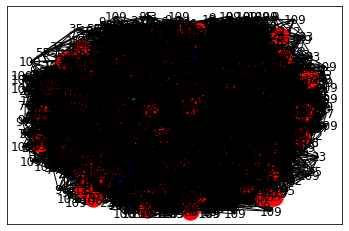

In [96]:
perform_all_efficiency_measures(graph,time_of_diffusion)

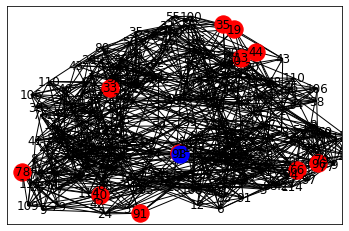

In [ ]:
# nx.draw(graph,)
nx.draw_networkx(graph,nodelist=O,node_color='r')
nx.draw_networkx(graph,nodelist=one,node_color='b')

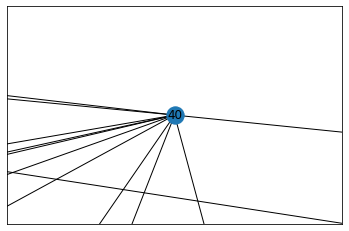

In [ ]:
show_true_node_in_graph = [truesource]
nx.draw_networkx(graph,nodelist=show_true_node_in_graph)